Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution that can evaluate images and alert dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [2]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
!unzip /content/gdrive/MyDrive/upgrad/CNN_assignment.zip -d /content/gdrive/MyDrive/upgrad/CNN_Assignment

Archive:  /content/gdrive/MyDrive/upgrad/CNN_assignment.zip
  inflating: /content/gdrive/MyDrive/upgrad/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010512.jpg  
  inflating: /content/gdrive/MyDrive/upgrad/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010889.jpg  
  inflating: /content/gdrive/MyDrive/upgrad/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024468.jpg  
  inflating: /content/gdrive/MyDrive/upgrad/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024470.jpg  
  inflating: /content/gdrive/MyDrive/upgrad/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024511.jpg  
  inflating: /content/gdrive/MyDrive/upgrad/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test

In [4]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/upgrad/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/upgrad/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [5]:
!ls

gdrive	sample_data


In [6]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters as per assignment guidelines for the loader:

In [7]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [8]:
## Creating train dataset here
## Using seed=123 while creating the dataset using tf.keras.preprocessing.image_dataset_from_directory
## Resizing the images to 180 x 180 while writting the dataset and a batch size of 32, as per assignment directions
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  labels='inferred',
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [9]:
## Creating validation dataset here
## Using seed=123 while creating the dataset using tf.keras.preprocessing.image_dataset_from_directory
## Resizing the images to 180 x 180 while writting the dataset and a batch size of 32, as per assignment directions
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  labels='inferred',
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [10]:
# List out all the classes of skin cancer and store them in a list.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [11]:
print(type(train_ds))
print(len(train_ds))

<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>
56


In [12]:
for images, labels in train_ds.take(1):
  print(len(images))
  print(len(labels))

32
32


### Visualizing the data

32
32


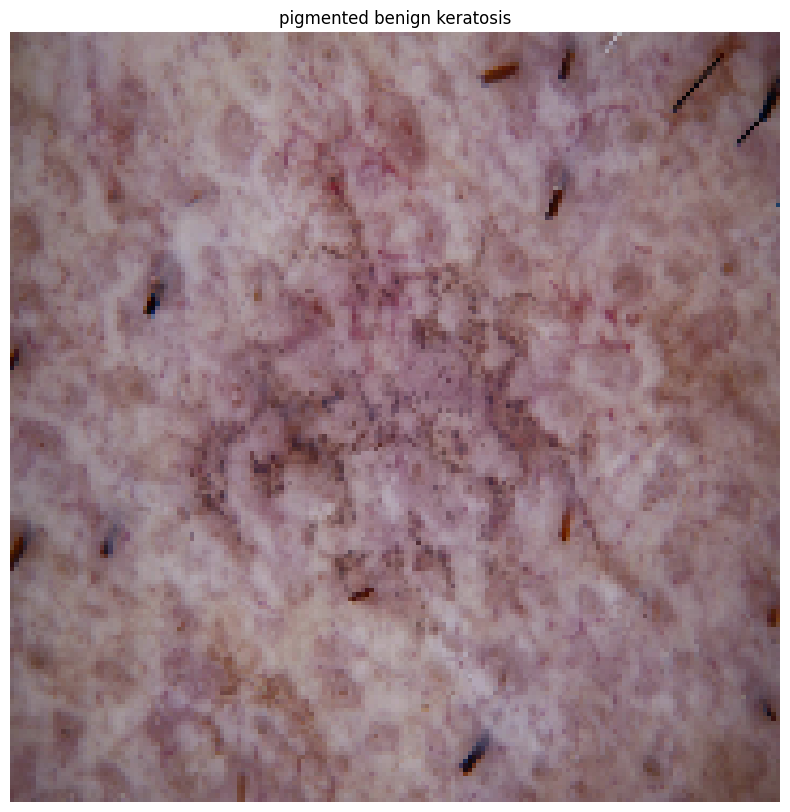

In [13]:

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  print(len(images))
  print(len(labels))
  plt.imshow(images[10].numpy().astype("uint8"))
  plt.title(class_names[labels[10]])
  plt.axis("off")


#### Visualizing one instance of all the nine classes present in the dataset



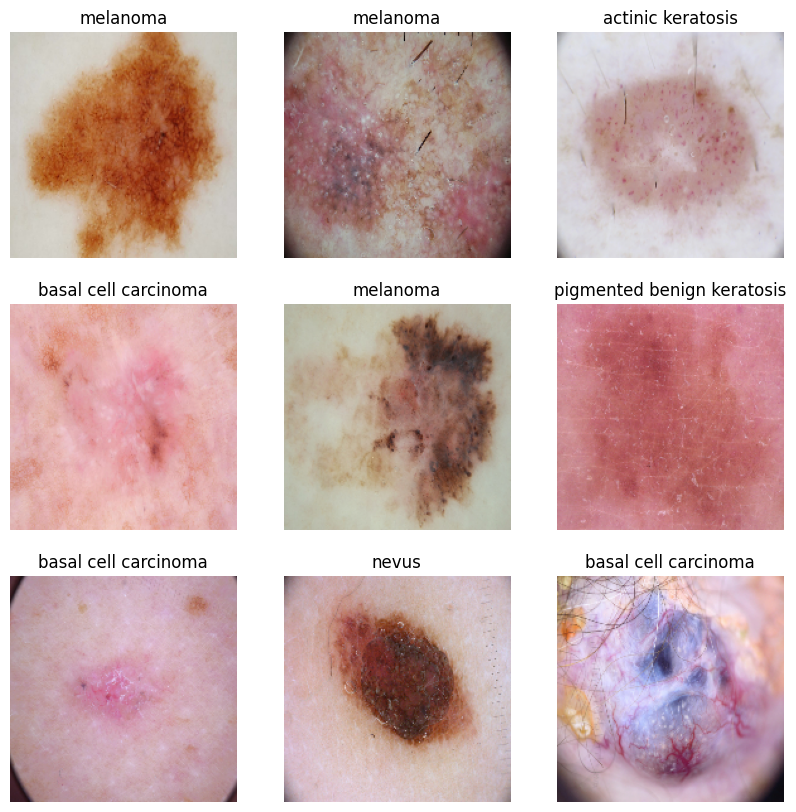

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(5):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [16]:
#overlaps data preprocessing and model execution while training., Speed up training
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Model building and training
#### Create a CNN model, which can accurately detect 9 classes present in the dataset.
#### While building the model, rescale images to normalize pixel values between (0,1).
#### Use layers.experimental.preprocessing.Rescaling to normalize pixel values between (0,1). The RGB channel values are in the [0, 255] range. This is not ideal for a neural network. Here, it is good to standardize values to be in the [0, 1]
#### Choose an appropriate optimiser and loss function for model training. Train the model for ~20 epochs

## Model 1 - Building a Sequential model with rescaling with 3 convolution and 2 Dense layers

In [17]:
num_classes = 9

# A Sequential model for a plain stack of layers
model = Sequential([
  # Rescaling layer
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

  # 1st 2D convolution layer
  layers.Conv2D(16, 3, padding='same', activation='relu'),

  # MaxPooling layer - taking maximum value over an input window along its spatial dimensions (height and width)
  layers.MaxPooling2D(),

  # 2nd 2D convolution layer
  layers.Conv2D(32, 3, padding='same', activation='relu'),

  # MaxPooling layer
  layers.MaxPooling2D(),

  # 3rd 2D convolution layer
  layers.Conv2D(64, 3, padding='same', activation='relu'),

  # MaxPooling layer - Decreased size of input for upcoming layers, Works against overfitting
  layers.MaxPooling2D(),

  #Flattening - Convert into 1D feature vector.  Flattens all its structure to create a single long feature vector
  layers.Flatten(),

  # 1st Dense / fully connected layer (A hidden layer in which each node is connected to every node in the subsequent hidden layer)
  layers.Dense(128, activation='relu'),

  # Output Dense layer that has 9 neurons representing the 9 classes in the dataset
  layers.Dense(num_classes)
])



### Compile the model
Choose an appropirate optimiser and loss function for model training

In [18]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [19]:
# Choosing adam as optimizer and SparseCategoricalCrossentropy as loss function.
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Train the model

In [20]:
# Train the model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 187s 894ms/step - loss: 2.0920 - accuracy: 0.2182 - val_loss: 1.9421 - val_accuracy: 0.2617
Epoch 2/20
56/56 [==============================] - 1s 19ms/step - loss: 1.8268 - accuracy: 0.3248 - val_loss: 1.6563 - val_accuracy: 0.4340
Epoch 3/20
56/56 [==============================] - 1s 20ms/step - loss: 1.5298 - accuracy: 0.4688 - val_loss: 1.5226 - val_accuracy: 0.4720
Epoch 4/20
56/56 [==============================] - 1s 21ms/step - loss: 1.4377 - accuracy: 0.4916 - val_loss: 1.4126 - val_accuracy: 0.4877
Epoch 5/20
56/56 [==============================] - 1s 22ms/step - loss: 1.3177 - accuracy: 0.5290 - val_loss: 1.4051 - val_accuracy: 0.5168
Epoch 6/20
56/56 [==============================] - 1s 21ms/step - loss: 1.2672 - accuracy: 0.5580 - val_loss: 1.5078 - val_accuracy: 0.4966
Epoch 7/20
56/56 [==============================] - 1s 19ms/step - loss: 1.1646 - accuracy: 0.5792 - val_loss: 1.4679 - val_accuracy: 0.4944
Epoch 8/20

## Visualizing the results

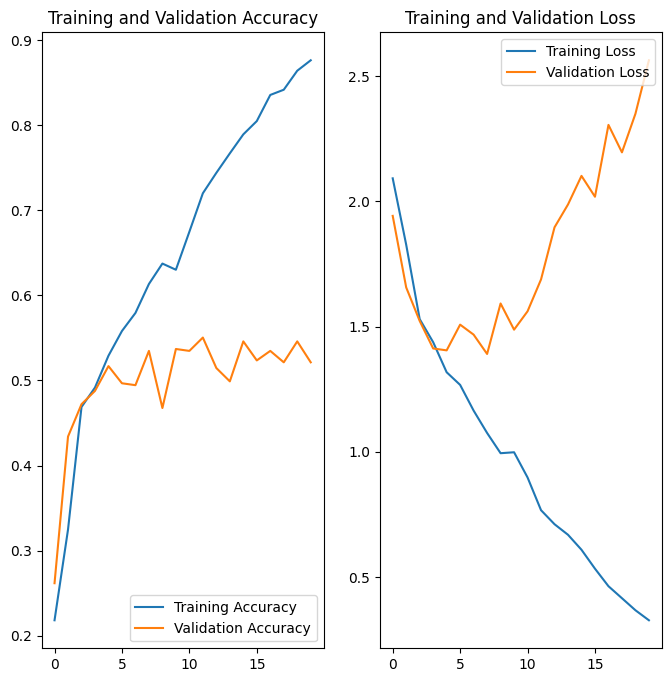

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Findings from Model 1
### Model is overfitting with training accuracy at 87% while the validation accuracy is at around 52%. A possible reason could be that the model is some symmetry with weights and biases and memorizing them. We can try breaking them in the next iteration.

### Model 2 - Building a Sequential model with data augmentation.
#### Data augmentation strategy being applied to address overfitting. A Dropout layer is added for the same purpose.

In [22]:
# Choosing an appropriate data augumentation strategy to address model overfitting in this case.
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal",
                                                 input_shape=(img_height,
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
    layers.experimental.preprocessing.RandomTranslation(1,.5,fill_mode="reflect",interpolation="bilinear",seed=None,fill_value=0.0),
    layers.experimental.preprocessing.RandomCrop(img_height,img_width),
  ]
)

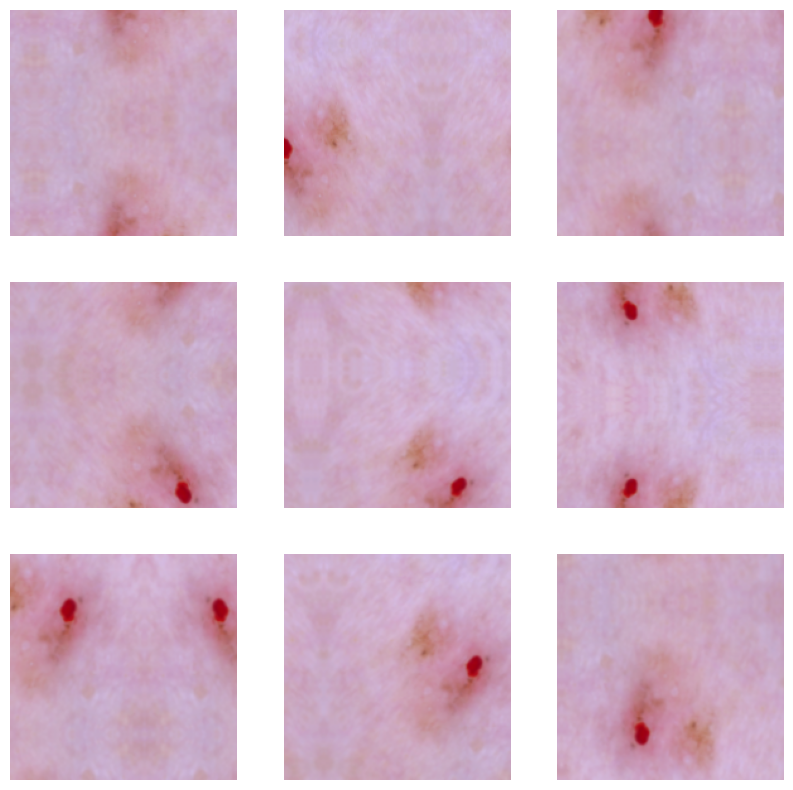

In [23]:
# Visualize how the augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Creating the 2nd model, compile and train the model
#### Model with rescaling layer, 3 convolution, a dropout layer and 2 Dense layers.

In [24]:
## Sequential model with 3 Conv layers, 1 Dropout layer, 2 Dense layers with Data augmentation applied

model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(256, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])



### Compiling the model

In [25]:
# Choosing adam as optimizer and SparseCategoricalCrossentropy as loss function.
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [26]:
# Train the model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 14s 145ms/step - loss: 2.3089 - accuracy: 0.1987 - val_loss: 2.0023 - val_accuracy: 0.2058
Epoch 2/20
56/56 [==============================] - 7s 120ms/step - loss: 2.0099 - accuracy: 0.2316 - val_loss: 1.9103 - val_accuracy: 0.2685
Epoch 3/20
56/56 [==============================] - 7s 130ms/step - loss: 1.9450 - accuracy: 0.2617 - val_loss: 1.8959 - val_accuracy: 0.1879
Epoch 4/20
56/56 [==============================] - 7s 118ms/step - loss: 1.7916 - accuracy: 0.3354 - val_loss: 1.6554 - val_accuracy: 0.3982
Epoch 5/20
56/56 [==============================] - 7s 119ms/step - loss: 1.6876 - accuracy: 0.3655 - val_loss: 1.6589 - val_accuracy: 0.4072
Epoch 6/20
56/56 [==============================] - 6s 115ms/step - loss: 1.8382 - accuracy: 0.3013 - val_loss: 1.7686 - val_accuracy: 0.3132
Epoch 7/20
56/56 [==============================] - 6s 115ms/step - loss: 1.7667 - accuracy: 0.3348 - val_loss: 1.7168 - val_accuracy: 0.3826
Epoch

### Visualizing the results

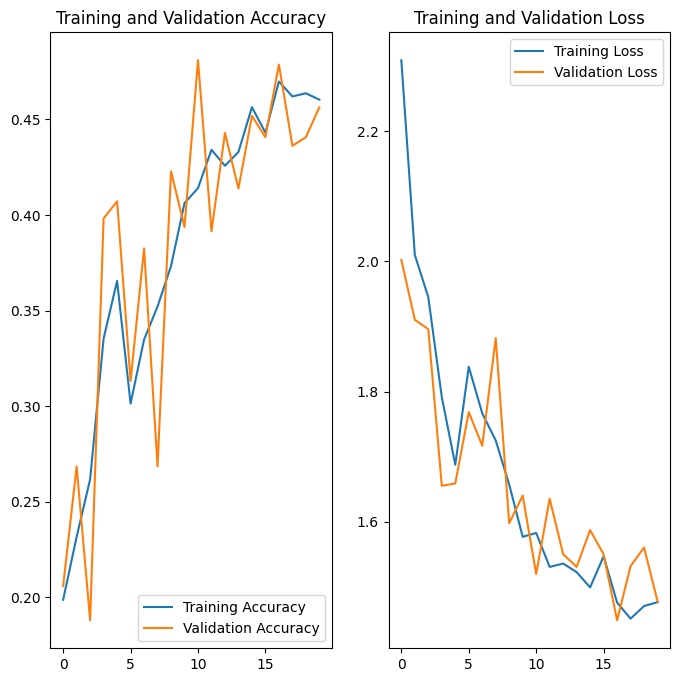

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Findings from Model 2
#### There is a significant improvement in the model performance compared to the previous model. As we can see from the train and validation accuracy - around 46% and 45% respectively, the overfitting has been addressed.
#### However, the accuracy is very low. In the next step, we will check whether there is a class imbalance issue in the dataset and address the same.

#### Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [28]:
# Get the list of all paths including sub directories represented by class names under train dataset.
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
len(path_list)

2239

In [29]:
# Create a dataframe containing the classname labels and the corresponding paths.
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/gdrive/MyDrive/upgrad/CNN_Assignment/...,actinic keratosis
1,/content/gdrive/MyDrive/upgrad/CNN_Assignment/...,actinic keratosis
2,/content/gdrive/MyDrive/upgrad/CNN_Assignment/...,actinic keratosis
3,/content/gdrive/MyDrive/upgrad/CNN_Assignment/...,actinic keratosis
4,/content/gdrive/MyDrive/upgrad/CNN_Assignment/...,actinic keratosis
...,...,...
2234,/content/gdrive/MyDrive/upgrad/CNN_Assignment/...,vascular lesion
2235,/content/gdrive/MyDrive/upgrad/CNN_Assignment/...,vascular lesion
2236,/content/gdrive/MyDrive/upgrad/CNN_Assignment/...,vascular lesion
2237,/content/gdrive/MyDrive/upgrad/CNN_Assignment/...,vascular lesion


Class=0, Class_Name=actinic keratosis n=114 (5.092%)
Class=1, Class_Name=basal cell carcinoma n=376 (16.793%)
Class=2, Class_Name=dermatofibroma n=95 (4.243%)
Class=3, Class_Name=melanoma n=438 (19.562%)
Class=4, Class_Name=nevus n=357 (15.945%)
Class=5, Class_Name=pigmented benign keratosis n=462 (20.634%)
Class=6, Class_Name=seborrheic keratosis n=77 (3.439%)
Class=7, Class_Name=squamous cell carcinoma n=181 (8.084%)
Class=8, Class_Name=vascular lesion n=139 (6.208%)


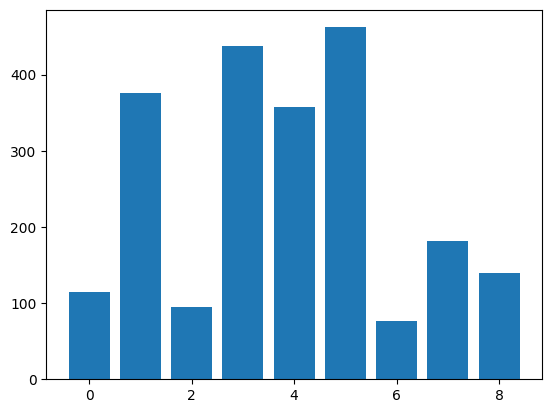

In [34]:
from sklearn.preprocessing import LabelEncoder
from collections import Counter
# split into input and output elements
X, y = original_df['Path'], original_df['Label']
# label encode the target variable
y = LabelEncoder().fit_transform(y)
# summarize distribution
counter = Counter(y)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d, Class_Name=%s n=%d (%.3f%%)' % (k, class_names[k], v, per))
# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()

#### Findings:
#### - "seborrheic keratosis" class has the least number of samples - 77.
#### - Classes, "pigmented benign keratosis" with 462 samples and "melanoma: with 438 samples classes dominate the data in terms proportionate number of samples.


## Rectify class imbalances present in the training dataset with Augmentor library.
#### **Context:** Will use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [35]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [36]:
path_to_training_dataset="/content/gdrive/MyDrive/upgrad/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train//"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/upgrad/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train//actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7DA114128CA0>: 100%|██████████| 500/500 [00:18<00:00, 27.76 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/upgrad/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train//basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7DA1A2674EE0>: 100%|██████████| 500/500 [00:19<00:00, 26.10 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/upgrad/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train//dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7DA099C9A9E0>: 100%|██████████| 500/500 [00:19<00:00, 25.38 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/upgrad/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train//melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=2198x1603 at 0x7DA117F50190>: 100%|██████████| 500/500 [01:27<00:00,  5.74 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/upgrad/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train//nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=824x719 at 0x7DA1005253F0>: 100%|██████████| 500/500 [01:16<00:00,  6.57 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/upgrad/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train//pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7DA117FB4BB0>: 100%|██████████| 500/500 [00:21<00:00, 23.28 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/upgrad/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train//seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7DA1A354C670>: 100%|██████████| 500/500 [00:39<00:00, 12.68 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/upgrad/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train//squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7DA117F50370>: 100%|██████████| 500/500 [00:18<00:00, 26.94 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/upgrad/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train//vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7DA08C2E2EF0>: 100%|██████████| 500/500 [00:18<00:00, 27.53 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [37]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [38]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['/content/gdrive/MyDrive/upgrad/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029141.jpg_c1dca19b-5a12-4806-ac6a-a2c1db37d91d.jpg',
 '/content/gdrive/MyDrive/upgrad/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031922.jpg_e6ec1aab-5cd7-4da4-9b59-dea4ef84a38a.jpg',
 '/content/gdrive/MyDrive/upgrad/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030655.jpg_e27436be-31be-4be0-9fd1-aa432168f194.jpg',
 '/content/gdrive/MyDrive/upgrad/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0028393.jpg_ade32bb1-5fac-4552-b86e-05a9be5f0e35.jpg',
 '/content/gdrive/MyDrive/upgrad/CNN_Assignment/Skin cancer ISIC The International Skin 

In [39]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [40]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [41]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

<ipython-input-41-17a6b079869a>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = original_df.append(df2)


In [42]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

## Model 3:  Train the model on the data created using Augmentor

In [43]:
batch_size = 32
img_height = 180
img_width = 180

#### Create a training dataset

In [44]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training', ## Todo choose the correct parameter value, so that only training data is refered to
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### Create a validation dataset

In [45]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### Create Model 3 (make sure to include normalization)

In [46]:
# Use AUTOTUNE to speed up training
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Sequential model with Rescaling layer (to nomralize the pixel values between (0,1)), 3 Convolution layers, 1 Dropout and 2 Dense layers
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

#### Compile the model (Choose optimizer and loss function appropriately)

In [47]:
## Compiling the model with "adam" optimizer and "SparseCategoricalCrossentroy" loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### Train the model for 30 epochs

In [48]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 38s 70ms/step - loss: 1.7822 - accuracy: 0.3186 - val_loss: 1.4528 - val_accuracy: 0.4328
Epoch 2/30
169/169 [==============================] - 4s 26ms/step - loss: 1.3889 - accuracy: 0.4798 - val_loss: 1.3407 - val_accuracy: 0.5071
Epoch 3/30
169/169 [==============================] - 4s 26ms/step - loss: 1.1778 - accuracy: 0.5632 - val_loss: 1.1276 - val_accuracy: 0.6058
Epoch 4/30
169/169 [==============================] - 4s 26ms/step - loss: 0.9980 - accuracy: 0.6376 - val_loss: 1.0671 - val_accuracy: 0.6422
Epoch 5/30
169/169 [==============================] - 4s 25ms/step - loss: 0.8134 - accuracy: 0.7096 - val_loss: 0.9915 - val_accuracy: 0.6741
Epoch 6/30
169/169 [==============================] - 4s 26ms/step - loss: 0.6569 - accuracy: 0.7671 - val_loss: 0.8604 - val_accuracy: 0.7082
Epoch 7/30
169/169 [==============================] - 5s 27ms/step - loss: 0.5251 - accuracy: 0.8112 - val_loss: 0.8328 - val_accuracy: 0.774

#### Visualize the model results

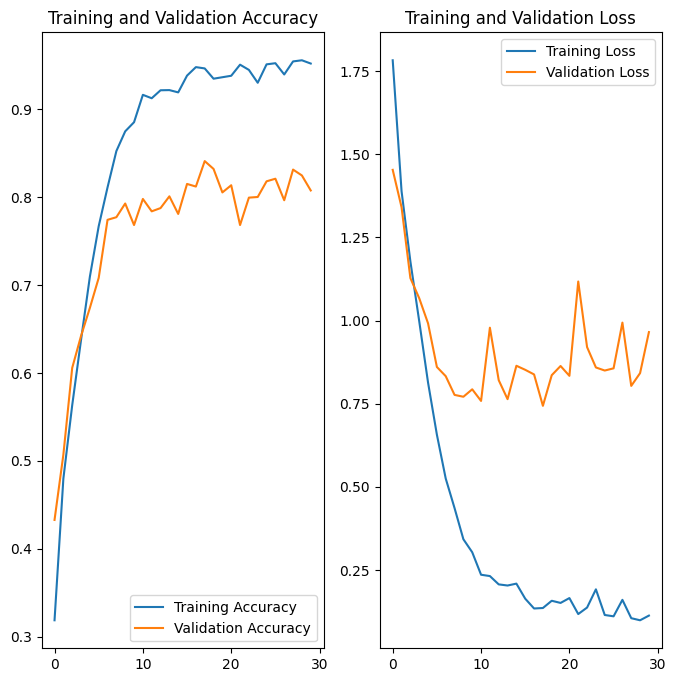

In [49]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Findings:  
#### The model performance has improved from the previous model in terms of model accuracy. While the training accuracy imporved to 95%, the validation accuracy improved to 80%.
#### However, the validation loss is also showing the increasing trend.
#### From the explanations offered in different forums, it could be the case of model not learning some classes well which is contributing to the increase in the loss.

